# Supervised learning

Author: Hank Feild  
Date: 2025-01-09

Demonstrates performing supervised learning over a dataset of housing data. Five models are deomonstrated:

  * regression: to predict selling prices of houses
    - linear regression
    - kNN (k-nearest neighbors)
    - deicsion tree
    - random forest
  * binary classification: to predict well above median selling price vs. not
    - logistic regression
    - kNN (k-nearest neighbors)
    - deicsion tree
    - random forest
  * multiclass classification: to predict low (below median), median, and high (above median) selling price
    - logistic regression
    - kNN (k-nearest neighbors)
    - deicsion tree
    - random forest
  
Several evaluation measures:

  * regression
    - $R^2$ (coefficient of correlation)
    - MSE (mean squared error)
    - RMSE (root mean squared error)
    - MedAE (median absolute error)
  * classification
    - accuracy
    - precision
    - recall
    - F1 (harmonic mean of precision and recall)
    - AuC/ROC (area under the receiver operating characteristic curve)

Other topics:

  * splitting data into training, development, and testing
  * stratifying data (for classification)
  * randomizing data (for both regression and classification)
  * balancing a data set (for classification)
  

In [1]:
# Modules needed -- everything that is needed is up here, but I've included commented out import statements
# in code cells that use a particular module.
import pandas as pd
from sklearn.model_selection import train_test_split # For created training/development/testing sets
from sklearn.preprocessing import MinMaxScaler # For normalizing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Regression evaluation modules
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import math

# Classification evaluation modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


/home/hfeild/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read in the data

In [2]:
# Read in the data, located in ../data/housing-all.csv
housingDF = pd.read_csv('../data/housing-all.csv')

# housingDF.describe()
housingDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,house_value
0,-117.62,33.43,23.0,4052.0,955.0,1950.0,859.0,4.0647,240600.0
1,-118.37,33.81,36.0,2031.0,339.0,817.0,337.0,5.1271,458300.0
2,-117.87,34.07,21.0,4723.0,882.0,2210.0,768.0,3.8167,258700.0
3,-117.37,33.19,33.0,2205.0,453.0,1138.0,439.0,2.8819,208600.0
4,-119.34,36.62,26.0,1922.0,339.0,1148.0,332.0,2.6058,92200.0


Suppose we want to predict `house_value` (that's our target or dependent variable (DV)). Let's start by segmenting our feature columns from the DV.

In [3]:
# TODO
features = housingDF.drop('house_value', axis=1)
# features = housingDF.drop(columns=['house_value']) # equivalent to previous line.
houseValues = housingDF['house_value']

features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-117.62,33.43,23.0,4052.0,955.0,1950.0,859.0,4.0647
1,-118.37,33.81,36.0,2031.0,339.0,817.0,337.0,5.1271
2,-117.87,34.07,21.0,4723.0,882.0,2210.0,768.0,3.8167
3,-117.37,33.19,33.0,2205.0,453.0,1138.0,439.0,2.8819
4,-119.34,36.62,26.0,1922.0,339.0,1148.0,332.0,2.6058


In [4]:
houseValues.head()

0    240600.0
1    458300.0
2    258700.0
3    208600.0
4     92200.0
Name: house_value, dtype: float64

## Data preparation

We want to develop three different targets for each observation:

  1. `house_value` (numeric) -- for regression (already present)
  2. `well_above_median` (binary) -- for binary classification (we need to make this column)
  3. `house_value_level` (categorical 0=low, 1=median, 2=high) -- for multiclass classification (we need to make this column)

For #2 and #3, we want to use the `house_value` stats from the training data to derive the necessary thresholds; this way, we're not learning from "unseen" development and test sets. For all of our models, I want to use the same training/development/test sets and I want them to be stratified. That essentially means we need the class labels from #2 and #3 *before* we split the dataset, thus violating our "keep test data unseen" rule—a classic chicken and egg problem!

So, here's what we'll do. We'll extract an initial set of thresholds for #3 above to assign a label of 0, 1, or 2 to every observation. We'll stratify on these labels when we make the training, development, and test sets. However, we will throw those labels away once we split. We'll then generate the labels for #2 and #3 using the `house_value` prices from only the training set. Our stratification may be a little off, but it should be close enough.

In [5]:
def houseValuesToCategory(houseValues):
    '''Calculates the 33rd and 66th percentiles of the given data, then
    returns a function that will classify a house prcie into low (0), median (1),
    or high (2) using those percentiles as treshold.
    
    Parameters:
        houseValues (Series): A series of numeric values.
        
    Returns (f(float)->int): A function that converts a price to 0, 1, or 2.
    '''
    # Find the 33rd and 66th percentile:
    # high: >= 66th percentile
    # median: between 33rd and 66th percentiles
    # low: < 33rd percentile
    upperThreshold = houseValues.quantile(.66)
    lowerThreshold = houseValues.quantile(.33)
    def f(price):
        if price < lowerThreshold:
            return 0
        elif price < upperThreshold:
            return 1
        else:
            return 2
    return f

In [6]:
# Map housing prices to low (0), median (1), or high (2).
categories = houseValues.map(houseValuesToCategory(houseValues))
categories

0        2
1        2
2        2
3        1
4        0
        ..
20428    2
20429    0
20430    0
20431    0
20432    2
Name: house_value, Length: 20433, dtype: int64

In [7]:
# This code does the same thing as the two previous cells, just written a different way
# if the above is confusing.
upperThreshold = houseValues.quantile(.66)
lowerThreshold = houseValues.quantile(.33)

# upperThreshold, lowerThreshold

def houseValueToCategory(price):
    if price < lowerThreshold:
        return 0
    elif price < upperThreshold:
        return 1
    else:
        return 2
    
categories = houseValues.map(houseValueToCategory)
categories

0        2
1        2
2        2
3        1
4        0
        ..
20428    2
20429    0
20430    0
20431    0
20432    2
Name: house_value, Length: 20433, dtype: int64

In [57]:
upperThreshold, lowerThreshold

(228000.0, 140556.00000000003)

In [9]:
# Make a dataframe to hold the house value and category of each row.
targets = pd.DataFrame({'house_value': houseValues, 'stratification_category': categories})

## Make training, dev, and test splits

We'll make them 60/20/20. We'll use a housing dataset to test with.

In [10]:
# from sklearn.model_selection import train_test_split

# First, break into (training+dev, 80%) and (testing, 20%), stratifying using the category.
trainDevFeatures, testFeatures, trainDevTargets, testTargets = \
    train_test_split(features, targets, train_size=.8, 
       shuffle=True, stratify=targets['stratification_category'])

# Second, break the trainDev set into (training, 75%) and (dev, 25%) -- 75% of 80% is 60% of the original:
# trainFeatures and devFeatures
# trainTargets and devTargets
# TODO
trainFeatures, devFeatures, trainTargets, devTargets = \
    train_test_split(trainDevFeatures, trainDevTargets, train_size=0.75, 
        shuffle=True, stratify=trainDevTargets['stratification_category'])

# So we can see what the data splits look like.
print(
    trainFeatures.shape,
    trainTargets.shape,
    devFeatures.shape,
    devTargets.shape,
    testFeatures.shape,
    testTargets.shape
)

(12259, 8) (12259, 2) (4087, 8) (4087, 2) (4087, 8) (4087, 2)


## Next, we're going to scale the features

Scaling will map all of the values of a particular feature into a given range; we'll do \[0,1\].

We'll do this by creating (fitting) a scaling model with the training features -- that'll find the min and max of "seen" data. Then we will run the dev and test features through that model. This way we don't use any extremes that occur only in the dev or test sets in our scaling model.

In [11]:
# from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

trainFeaturesScaled = trainFeatures.copy()
devFeaturesScaled = devFeatures.copy()
testFeaturesScaled = testFeatures.copy()

# Use `fit_transform()` for the training set (which uses the training set to extract the min and max,
# then scales all the values accordingly).
trainFeaturesScaled[trainFeaturesScaled.columns] = scaler.fit_transform(trainFeatures)

# Use `transform()` for the dev and test sets, which uses the min and max from the training set above
# to scales the features in deva and test.
devFeaturesScaled[devFeaturesScaled.columns] = scaler.transform(devFeatures)
testFeaturesScaled[testFeaturesScaled.columns] = scaler.transform(testFeatures)

In [12]:
trainFeaturesScaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
18973,0.710711,0.024468,0.725490,0.067653,0.080045,0.069255,0.092402,0.241776
18676,0.681682,0.146809,0.490196,0.075487,0.092608,0.132070,0.103976,0.238086
7677,0.206206,0.560638,1.000000,0.088484,0.120792,0.088394,0.133844,0.234486
10871,0.596597,0.141489,0.588235,0.079353,0.116927,0.115446,0.133284,0.232121
6037,0.702703,0.172340,0.490196,0.078946,0.096956,0.085450,0.107336,0.184391
...,...,...,...,...,...,...,...,...
11433,0.250250,0.765957,0.196078,0.183377,0.218071,0.200037,0.235766,0.180177
19004,0.286286,0.640426,1.000000,0.078285,0.087615,0.059625,0.092216,0.225935
7180,0.219219,0.578723,0.176471,0.072791,0.082622,0.079561,0.094456,0.268107
14016,0.640641,0.162766,0.607843,0.052546,0.057175,0.059686,0.068882,0.324968


In [14]:
scaler.data_min_

array([-124.3   ,   32.55  ,    1.    ,    2.    ,    1.    ,    3.    ,
          1.    ,    0.4999])

In [15]:
scaler.data_max_

array([-1.14310e+02,  4.19500e+01,  5.20000e+01,  3.93200e+04,
        6.21000e+03,  1.63050e+04,  5.35800e+03,  1.50001e+01])

## Regression

In this section, we'll look at predicting `house_price`, which is a numeric feature.

### Linear regression

Our first algorithm up is linear regression. We'll look at training two different models: one that uses just three features and one that uses all 8 features.

For this first one, let's create a model where we use just the total rooms, total bedrooms, and the median income of the area as features, and house value as the dependent variable that we want to predict.

In [16]:
# from sklearn.linear_model import LinearRegression
## Other linear regression algorithms:
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso

featureNames = ['total_rooms', 'total_bedrooms', 'median_income']
linearReg1 = LinearRegression()
linearReg1.fit(trainFeaturesScaled[featureNames], trainTargets['house_value'])

LinearRegression()

#### What do the coefficients tell us? How about the intercept?

Remember that linear regression learning a y-intercept ($\beta_0$) and one weight per feature ($\beta_1, \ldots, \beta_n$). The feature weights are called coefficients. We can extract both of them from the model and display them as a formula. This helps us understand what the most important features are.

In [17]:
print(
    linearReg1.coef_,
    linearReg1.intercept_
)

print(f'price = {linearReg1.intercept_} ', end="")
for coef,feature in zip(linearReg1.coef_, featureNames):
    print(f'+ {coef}*{feature} ', end="")
print()

[-1216434.53709003  1028804.76614916   713678.93597547] 33601.38581390731
price = 33601.38581390731 + -1216434.537090032*total_rooms + 1028804.7661491553*total_bedrooms + 713678.9359754719*median_income 


#### Making predictions with the model

Now we'll make predictions on the development set.

In [18]:
# Make predictions on the development set.
devLinearReg1Pred = linearReg1.predict(devFeaturesScaled[featureNames])

In [19]:
devLinearReg1Pred

array([170195.50090013, 102117.47330566, 252568.29009589, ...,
       458478.25894547, 108792.42286293, 178161.47501704])

In [20]:
devTargets['house_value']

6655     182400.0
10165     86100.0
9557     207000.0
5989      95000.0
5312     188800.0
           ...   
16558    193500.0
13622    117000.0
7777     500001.0
2970      88200.0
5675     141400.0
Name: house_value, Length: 4087, dtype: float64

#### Regression evaluation

Let's evaluate!

Here, I define a function that can be used with any regression -- just give it the actual values and the predicted labels and it will print out the evaluations.

In [21]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error
# import math

def evaluateRegression(actuals, predictions):
    '''Evalutes a set of numeric predictions given the actual values; MSE, RMSE, R^2, and MedAE are all reported.
    Evaluation results are printed.
    
    Parameters:
        actuals (sequence): A list of the true value for each observation.
        predictions (sequence): A list of the predicted value for each observation.    
    '''
    print(f"MSE: {mean_squared_error(actuals, predictions)}")
    print(f"\tRMSE: {math.sqrt(mean_squared_error(actuals, predictions))}")
    print(f"r2: {r2_score(actuals, predictions)}")
    print(f"MedAE: {median_absolute_error(actuals, predictions)}")

In [22]:
# Evaluate our first linear regression model. 
evaluateRegression(devTargets['house_value'], devLinearReg1Pred)

MSE: 6682140142.626388
	RMSE: 81744.35847583848
r2: 0.5070550546174979
MedAE: 46929.94731395799


#### Slightly different linear regression model

Let's try making a model that uses *all* the features that aren't the DV (house value). -- Use the same training and development sets!

In [23]:
# Choose the features.
# "Fit" or "learn" the model
featureNames = trainFeaturesScaled.columns
linearReg2 = LinearRegression()
linearReg2.fit(trainFeaturesScaled[featureNames], trainTargets['house_value'])

# Describe the model.
print(f'price = {linearReg2.intercept_} ', end="")
for coef,feature in zip(linearReg2.coef_, featureNames):
    print(f'+ {coef}*{feature} ', end="")
print()

# Make predictions with the model.
devLinearReg2Pred = linearReg2.predict(devFeaturesScaled[featureNames])

# Evaluate the predictions.
evaluateRegression(devTargets['house_value'], devLinearReg2Pred)

price = 369487.5990823542 + -433291.4438115117*longitude + -406553.52040933823*latitude + 60967.22323847226*housing_median_age + -284926.6179826653*total_rooms + 711294.3382900248*total_bedrooms + -714597.0223603257*population + 293429.91176152695*households + 583237.2608088888*median_income 
MSE: 4903950924.682356
	RMSE: 70028.21520417578
r2: 0.6382329958473643
MedAE: 38763.34268008874


###  kNN Regression

In [50]:
# from sklearn.neighbors import KNeighborsRegressor

# Choose the features.
# "Fit" or "learn" the model
featureNames = trainFeaturesScaled.columns

for k in [3, 5, 7, 9]:
    print(f'k: {k}:')
    knnModel = KNeighborsRegressor(n_neighbors=k)
    knnModel.fit(trainFeaturesScaled[featureNames], trainTargets['house_value'])

    # We can't "describe" the model like we did for linear regression.

    # Make predictions with the model.
    devKNNPred = knnModel.predict(devFeaturesScaled[featureNames])

    # Evaluate the predictions.
    evaluateRegression(devTargets['house_value'], devKNNPred)
    print()

k: 3:
MSE: 4334737519.613518
	RMSE: 65838.72355698823
r2: 0.6802241640784397
MedAE: 26966.666666666686

k: 5:
MSE: 3975338953.124022
	RMSE: 63050.289080415976
r2: 0.706737182804066
MedAE: 27920.0

k: 7:
MSE: 3933443397.432986
	RMSE: 62717.16987741862
r2: 0.709827839685107
MedAE: 27857.142857142855

k: 9:


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


MSE: 3940157425.00793
	RMSE: 62770.673287833466
r2: 0.7093325423872974
MedAE: 28411.11111111111



### Decision tree regression

In [49]:
# from sklearn.tree import DecisionTreeRegressor

# Choose the features.
# "Fit" or "learn" the model
featureNames = trainFeaturesScaled.columns

# for depth in [2, 5, 10, 20, 40]:
for leafNodes in [50, 100, 200, 300, 500]:
#     print(f'Max tree depth: {depth}:')
    print(f'Max leaf nodes: {leafNodes}:')
#     decisionTreeModel = DecisionTreeRegressor(max_depth=depth)
    decisionTreeModel = DecisionTreeRegressor(max_leaf_nodes=leafNodes)
    decisionTreeModel.fit(trainFeaturesScaled[featureNames], trainTargets['house_value'])

    # # We can't "describe" the model like we did for linear regression, but we can plot it!
    # from sklearn.tree import plot_tree
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(20,10))
    # plot_tree(decisionTreeModel, max_depth=3, fontsize=8, feature_names=featureNames)

    # Make predictions with the model.
    devDecisionTreePred = decisionTreeModel.predict(devFeaturesScaled[featureNames])

    # Evaluate the predictions.
    evaluateRegression(devTargets['house_value'], devDecisionTreePred)
    print()

Max leaf nodes: 50:
MSE: 4356953191.346942
	RMSE: 66007.2207515734
r2: 0.6785853024479553
MedAE: 35308.25242718446

Max leaf nodes: 100:
MSE: 4024630584.0229225
	RMSE: 63439.976229684406
r2: 0.7031009136174515
MedAE: 30824.096385542172

Max leaf nodes: 200:
MSE: 3772078981.132085
	RMSE: 61417.25312265345
r2: 0.7217317764003376
MedAE: 28174.21875

Max leaf nodes: 300:
MSE: 3764149208.1616774
	RMSE: 61352.66260042573
r2: 0.7223167598667659
MedAE: 26849.033333333326

Max leaf nodes: 500:
MSE: 4020126361.264874
	RMSE: 63404.466414164184
r2: 0.7034331924673507
MedAE: 25164.356435643567



### Random forest regression

In [55]:
# from sklearn.ensemble import RandomForestRegressor

# Choose the features.
# "Fit" or "learn" the model
featureNames = trainFeaturesScaled.columns
randomForestModel = RandomForestRegressor(n_estimators=100)
randomForestModel.fit(trainFeaturesScaled[featureNames], trainTargets['house_value'])

# We can't "describe" the model like we did for linear regression.

# Make predictions with the model.
devRandomForestPred = randomForestModel.predict(devFeaturesScaled[featureNames])

# Evaluate the predictions.
evaluateRegression(devTargets['house_value'], devRandomForestPred)

MSE: 2403349410.439882
	RMSE: 49023.967714168975
r2: 0.8227036670023046
MedAE: 20674.0


### New model

Let's consider whether median household age is a good predictor all on its own. How do we do it?

In [ ]:
# TODO

## Binary Classification 

### The class labels

This is essentially the same thing as the regression algorithms we used above in terms of set up, etc. However, logistic regression is used for performing *binary classification*—we're trying to predict "yes"/"no" or "class 1"/"class 2". The scikit-learn logistic regression function wants the Y values to be 0/1, so we need to map our class labels to 0/1.

We can create a binary classification problem out of just about anything. For the housing dataset we processed above, let's look at the spread of house values in the training set and see if we can establish a "really expensive" vs. "not really expensive" class. 

Specifically, let's riff off of the `houseValuesToCategory()` function we defined earlier that mapped housing pricess to 0 (0–33rd percentile), 1 (33rd–66th percentile), or 2 (66th–100th percentile). For binary classification, let's use the 66th-percentile as our thresold -- anything higher than that is class 1, everything else is class 0.

**We should not use the `stratification_categories` for this!** Those were created using the entire dataset, including the data that eventually went into development and test. We don't want to use that information in generating labels, however, or we risk leaking information about the test data.

In [56]:
# Step 1: find the 66th percentile of house_value in the training data.

topThirdThreshold = trainTargets['house_value'].quantile(.66)
topThirdThreshold

228000.0

In [58]:
# Step 2: For the training, development, and test sets, add a new column `well_above_median` to the *Target DataFrame,
# mapping all `house_value`s equal to or above the threshold we just found to be 1, all others to be 0.

# Training set
trainTargets['well_above_median'] = trainTargets['house_value'].map(
    lambda houseValue: 1 if houseValue >= topThirdThreshold else 0)

# Development set
devTargets['well_above_median'] = devTargets['house_value'].map(
    lambda houseValue: 1 if houseValue >= topThirdThreshold else 0)

# Test set
testTargets['well_above_median'] = testTargets['house_value'].map(
    lambda houseValue: 1 if houseValue >= topThirdThreshold else 0)

In [59]:
trainTargets

,house_value,stratification_category,well_above_median
18973,241600.0,2,1
18676,124600.0,0,0
7677,275700.0,2,1
10871,298400.0,2,1
6037,122200.0,0,0
...,...,...,...
11433,122600.0,0,0
19004,164500.0,1,0
7180,287700.0,2,1
14016,201200.0,1,0


### Logistic regression

This is the first of the binary classification algorithms we'll consider. It looks a lot like linear regression; the only difference will be the name of the class and we'll use the binarized house values.

In [60]:
# from sklearn.linear_model import LogisticRegression

logisticRegBinary = LogisticRegression()
logisticRegBinary.fit(trainFeaturesScaled, trainTargets['well_above_median'])

LogisticRegression()

In [61]:
# What are these?

print(
    logisticRegBinary.coef_,
    logisticRegBinary.intercept_
)

[[-12.23567522 -11.18532268   1.78595617   0.97288438   6.56973456
   -9.89682213   5.25396135  14.02680657]] [3.9131599]


In [62]:
# This bit of code will print out the features by importance; we could use very similar code with 
# linear regression, as well.

featureImportance = sorted(list(zip(logisticRegBinary.coef_[0], trainFeaturesScaled.columns)), key=lambda a: -abs(a[0]))

for coef,feature in featureImportance:
    print(f'{feature:>20}: {coef:>10.5f}')
print()

       median_income:   14.02681
           longitude:  -12.23568
            latitude:  -11.18532
          population:   -9.89682
      total_bedrooms:    6.56973
          households:    5.25396
  housing_median_age:    1.78596
         total_rooms:    0.97288



In [63]:
# Make predictions on the development set.

# Predict the class (0 or 1).
devLogisticRegBinaryPred = logisticRegBinary.predict(devFeaturesScaled)
devLogisticRegBinaryPred

array([0, 0, 1, ..., 1, 0, 0])

In [64]:
# Returns the raw probability of the 0 and 1 class. This is needed for some measures, like AUC.
devLogisticRegBinaryProbs = logisticRegBinary.predict_proba(devFeaturesScaled)
devLogisticRegBinaryProbs

array([[0.9152967 , 0.0847033 ],
       [0.98110406, 0.01889594],
       [0.45504538, 0.54495462],
       ...,
       [0.00250698, 0.99749302],
       [0.95287596, 0.04712404],
       [0.75959587, 0.24040413]])

#### Classification evaluation

Evaluation is also similar, but with different metrics. Area under the receiver operator characteristic curve (`roc_auc_score`) requires the predictions—what is the `[:,1]` bit about?

In [65]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import roc_auc_score

def evaluateBinaryClassification(actuals, binaryPredictions, probPredictions):
    '''Evalutes a set of binary class predictions given the actual values; accuracy, precision,
    recall, F1, and area under the receiver operator characteristic curve (AUC) are all reported.
    Assumes 1 is the positive class. Evaluation results are printed. 
    
    Parameters:
        actuals (sequence): A list of the true value for each observation.
        binaryPredictions (sequence): A list of the predicted class value for each observation.    
        probPredictions (sequence): A list of the predicted class probability distributions; each item should contain
                                    a list of class probabilities, one per class; assumes positive class is second.
    '''
    print(f'{"Accuracy":12}: {accuracy_score(actuals, binaryPredictions):>2.4f}')
    print(f'{"Precision":12}: {precision_score(actuals, binaryPredictions):>2.4f}')
    print(f'{"Recall":12}: {recall_score(actuals, binaryPredictions):>2.4f}')
    print(f'{"F1":12}: {f1_score(actuals, binaryPredictions):>2.4f}')
    print(f'{"AUC":12}: {roc_auc_score(actuals, probPredictions[:,1]):>2.4f}')

**Is our model any good?**

In [66]:
evaluateBinaryClassification(devTargets['well_above_median'], devLogisticRegBinaryPred, devLogisticRegBinaryProbs)

Accuracy    : 0.8427
Precision   : 0.8049
Recall      : 0.7094
F1          : 0.7541
AUC         : 0.9107


## k-Nearest Neighbors

Let's train a kNN model on the same features.

In [69]:
# from sklearn.neighbors import KNeighborsClassifier

for k in [3, 5, 7, 9, 11, 13]:
    print(f'k: {k}')
    knnBinary = KNeighborsClassifier(n_neighbors=k) # use k=5
    knnBinary.fit(trainFeaturesScaled.values, trainTargets['well_above_median'])
    devKNNBinaryPred = knnBinary.predict(devFeaturesScaled.values, )
    devKNNBinaryProbs = knnBinary.predict_proba(devFeaturesScaled.values)

    evaluateBinaryClassification(devTargets['well_above_median'], devKNNBinaryPred, devKNNBinaryProbs)
    print()

k: 3
Accuracy    : 0.8422
Precision   : 0.7881
Recall      : 0.7331
F1          : 0.7596
AUC         : 0.8864

k: 5


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.8529
Precision   : 0.8084
Recall      : 0.7439
F1          : 0.7748
AUC         : 0.9075

k: 7
Accuracy    : 0.8525
Precision   : 0.8145
Recall      : 0.7331
F1          : 0.7717
AUC         : 0.9126

k: 9


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.8481
Precision   : 0.8154
Recall      : 0.7151
F1          : 0.7620
AUC         : 0.9156

k: 11
Accuracy    : 0.8483
Precision   : 0.8192
Recall      : 0.7108
F1          : 0.7612
AUC         : 0.9180

k: 13


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.8495
Precision   : 0.8184
Recall      : 0.7165
F1          : 0.7641
AUC         : 0.9177



## Decision Tree

In [72]:
# from sklearn.tree import DecisionTreeClassifier

for leafNodes in [None, 50, 100, 200, 300, 400]:
    print(f'Max leaf nodes: {leafNodes}')
    decisionTreeBinary  = DecisionTreeClassifier(max_leaf_nodes=leafNodes)
    decisionTreeBinary.fit(trainFeaturesScaled.values, trainTargets['well_above_median'])
    decisionTreeBinaryPred = decisionTreeBinary.predict(devFeaturesScaled.values, )
    decisionTreeBinaryProbs = decisionTreeBinary.predict_proba(devFeaturesScaled.values)

    evaluateBinaryClassification(devTargets['well_above_median'], decisionTreeBinaryPred, decisionTreeBinaryProbs)
    print()

Max leaf nodes: None
Accuracy    : 0.8622
Precision   : 0.7973
Recall      : 0.7978
F1          : 0.7976
AUC         : 0.8466

Max leaf nodes: 50
Accuracy    : 0.8657
Precision   : 0.8252
Recall      : 0.7676
F1          : 0.7954
AUC         : 0.9192

Max leaf nodes: 100
Accuracy    : 0.8733
Precision   : 0.8354
Recall      : 0.7813
F1          : 0.8074
AUC         : 0.9199

Max leaf nodes: 200
Accuracy    : 0.8772
Precision   : 0.8318
Recall      : 0.8007
F1          : 0.8160
AUC         : 0.9137

Max leaf nodes: 300
Accuracy    : 0.8755
Precision   : 0.8251
Recall      : 0.8043
F1          : 0.8146
AUC         : 0.8918

Max leaf nodes: 400
Accuracy    : 0.8762
Precision   : 0.8284
Recall      : 0.8022
F1          : 0.8151
AUC         : 0.8794



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# TODO

## Multi-class classification

If we have more than two possible class labels, ten we have a multi-class classification problem. Of the algorithms we've considered, logistic regression is the only one that is limited to binary classification. However, the implementation of logistic regression in scikit learn allows for multi-class classification. It does this by breaking the problem into multiple binary classificiation problems. 

Let's get started by making the new multi-class labels, which are essentially the same that we used at the begining of this example to stratify the data sets. In fact, we can use the same function, just make sure to give it the training house values.

In [73]:
# Step 1: call houseValueToCategory over the training house values; this will return a function
# we can use to map te house values in each set to 0 (below median), 1 (median), or 2 (above median).
mapper = houseValuesToCategory(trainTargets['house_value'])

# Step 2: For the training, development, and test sets, add a new column `well_above_median` to the *Target DataFrame,
# mapping all `house_value`s equal to or above the threshold we just found to be 1, all others to be 0.

# Training set
trainTargets['house_value_level'] = trainTargets['house_value'].map(mapper)

# Development set
devTargets['house_value_level'] = devTargets['house_value'].map(mapper)

# Test set
testTargets['house_value_level'] = testTargets['house_value'].map(mapper)

### Multiclass Logitic regression

In [75]:
logisticRegMulticlass  = LogisticRegression(max_iter=1000)
logisticRegMulticlass.fit(trainFeaturesScaled.values, trainTargets['house_value_level'])
logisticRegMulticlassPred = logisticRegMulticlass.predict(devFeaturesScaled.values, )
logisticRegMulticlassProbs = logisticRegMulticlass.predict_proba(devFeaturesScaled.values)

In [76]:
# Class predictions
logisticRegMulticlassPred

array([0, 0, 2, ..., 2, 0, 1])

In [77]:
# Class label probability distributions.
logisticRegMulticlassProbs

array([[5.31720201e-01, 3.95221843e-01, 7.30579559e-02],
       [8.68802627e-01, 1.24149307e-01, 7.04806612e-03],
       [4.75449529e-02, 4.09908505e-01, 5.42546542e-01],
       ...,
       [4.31616273e-06, 6.02870433e-03, 9.93966980e-01],
       [6.34748569e-01, 3.35004300e-01, 3.02471302e-02],
       [3.11357126e-01, 4.47107174e-01, 2.41535700e-01]])

#### Evaluating multiclass classification

In [78]:
# Scikit learn supports multiclass classification evaluation metrics for many of the binary classification metrics.

def evaluateMulticlassClassification(actuals, classPredictions, probPredictions):
    '''Evalutes a set of multi-class predictions given the actual values; accuracy, precision,
    recall, F1, and area under the receiver operator characteristic curve (AUC) are all reported.
    Assumes 1 is the positive class. Evaluation results are printed. 
    
    Parameters:
        actuals (sequence): A list of the true value for each observation.
        classPredictions (sequence): A list of the predicted class value for each observation.    
        probPredictions (sequence): A list of the predicted class probability distributions; each item should contain
                                    a list of class probabilities, one per class.
    '''
    print(f'{"Accuracy":12}: {accuracy_score(actuals, classPredictions):>2.4f}')
    print(f'{"Precision":12}: {precision_score(actuals, classPredictions, average="weighted"):>2.4f}')
    print(f'{"Recall":12}: {recall_score(actuals, classPredictions, average="weighted"):>2.4f}')
    print(f'{"F1":12}: {f1_score(actuals, classPredictions, average="weighted"):>2.4f}')
    print(f'{"AUC":12}: {roc_auc_score(actuals, probPredictions, multi_class="ovr", average="weighted"):>2.4f}')

In [79]:
evaluateMulticlassClassification(devTargets['house_value_level'], logisticRegMulticlassPred, logisticRegMulticlassProbs)

Accuracy    : 0.7061
Precision   : 0.7018
Recall      : 0.7061
F1          : 0.7035
AUC         : 0.8686


### Multiclass kNN

In [82]:
for k in [3, 5, 7, 9, 11, 13]:
    print(f'k: {k}')
    knnMulticlass  = KNeighborsClassifier(n_neighbors=k)
    knnMulticlass.fit(trainFeaturesScaled.values, trainTargets['house_value_level'])
    knnMulticlassPred = knnMulticlass.predict(devFeaturesScaled.values, )
    knnMulticlassProbs = knnMulticlass.predict_proba(devFeaturesScaled.values)

    evaluateMulticlassClassification(devTargets['house_value_level'], knnMulticlassPred, knnMulticlassProbs)
    print()

k: 3
Accuracy    : 0.7091
Precision   : 0.7095
Recall      : 0.7091
F1          : 0.7085
AUC         : 0.8538

k: 5


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.7233
Precision   : 0.7255
Recall      : 0.7233
F1          : 0.7236
AUC         : 0.8732

k: 7
Accuracy    : 0.7220
Precision   : 0.7250
Recall      : 0.7220
F1          : 0.7229
AUC         : 0.8787

k: 9


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.7213
Precision   : 0.7254
Recall      : 0.7213
F1          : 0.7224
AUC         : 0.8822

k: 11
Accuracy    : 0.7240
Precision   : 0.7288
Recall      : 0.7240
F1          : 0.7254
AUC         : 0.8834

k: 13


/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/hfeild/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Accuracy    : 0.7247
Precision   : 0.7297
Recall      : 0.7247
F1          : 0.7264
AUC         : 0.8838



### Multiclass Deicsion tree

In [83]:
for leafNodes in [None, 50, 100, 200, 300, 400]:
    print(f'Max leaf nodes: {leafNodes}')
    decisionTreeMulticlass  = DecisionTreeClassifier(max_leaf_nodes=leafNodes)
    decisionTreeMulticlass.fit(trainFeaturesScaled.values, trainTargets['house_value_level'])
    decisionTreeMulticlassPred = decisionTreeMulticlass.predict(devFeaturesScaled.values, )
    decisionTreeMulticlassProbs = decisionTreeMulticlass.predict_proba(devFeaturesScaled.values)

    evaluateMulticlassClassification(devTargets['house_value_level'], decisionTreeMulticlassPred, decisionTreeMulticlassProbs)
    print()

Max leaf nodes: None
Accuracy    : 0.7477
Precision   : 0.7492
Recall      : 0.7477
F1          : 0.7484
AUC         : 0.8110

Max leaf nodes: 50
Accuracy    : 0.7492
Precision   : 0.7588
Recall      : 0.7492
F1          : 0.7511
AUC         : 0.8902

Max leaf nodes: 100
Accuracy    : 0.7646
Precision   : 0.7661
Recall      : 0.7646
F1          : 0.7653
AUC         : 0.9014

Max leaf nodes: 200
Accuracy    : 0.7756
Precision   : 0.7761
Recall      : 0.7756
F1          : 0.7756
AUC         : 0.9052

Max leaf nodes: 300
Accuracy    : 0.7764
Precision   : 0.7759
Recall      : 0.7764
F1          : 0.7761
AUC         : 0.8998

Max leaf nodes: 400
Accuracy    : 0.7810
Precision   : 0.7805
Recall      : 0.7810
F1          : 0.7807
AUC         : 0.8897



### Multiclass Random forest

In [85]:
for trees in [10, 50, 100, 200, 300, 400]:
    print(f'Trees: {trees}')
    randomForestMulticlass  = RandomForestClassifier(n_estimators=trees)
    randomForestMulticlass.fit(trainFeaturesScaled.values, trainTargets['house_value_level'])
    randomForestMulticlassPred = randomForestMulticlass.predict(devFeaturesScaled.values, )
    randomForestMulticlassProbs = randomForestMulticlass.predict_proba(devFeaturesScaled.values)


    evaluateMulticlassClassification(devTargets['house_value_level'], randomForestMulticlassPred, randomForestMulticlassProbs)
    print()

Trees: 10
Accuracy    : 0.7624
Precision   : 0.7628
Recall      : 0.7624
F1          : 0.7622
AUC         : 0.9058

Trees: 50
Accuracy    : 0.7888
Precision   : 0.7895
Recall      : 0.7888
F1          : 0.7890
AUC         : 0.9299

Trees: 100
Accuracy    : 0.7932
Precision   : 0.7936
Recall      : 0.7932
F1          : 0.7933
AUC         : 0.9312

Trees: 200
Accuracy    : 0.7969
Precision   : 0.7970
Recall      : 0.7969
F1          : 0.7969
AUC         : 0.9335

Trees: 300
Accuracy    : 0.8006
Precision   : 0.8013
Recall      : 0.8006
F1          : 0.8009
AUC         : 0.9339

Trees: 400
Accuracy    : 0.8021
Precision   : 0.8023
Recall      : 0.8021
F1          : 0.8021
AUC         : 0.9343



# Balancing datasets

In classifictation, balanced datasets provide an equal number of observations corresponding to each class. If you have a dataset where there is an imbalance, there are several ways you can rectify it. A couple of simple approaches are:

  * oversample observations of the class that is underrepresented
  * undersample observations of the class that is overrepresented
  * create synthetic observations of the class that is underrepresented
  * some combination of these
  
The first is pretty simple and doesn't throw away data. It works as follows. Assume the underrepresented class is A and the overrepresented class is B. Let $n$ be the number of observations of class A and $m$ be the number of observations of class B. $m-n$ times we will randomly choose one of the $n$ observations of class A and add them to a separat set. The same observation can be picked multiple times (this is called random sampling with replacement). We now combine the $n$ original observations of class A, the $m-n$ duplicated observations, and the $m$ observations of class B to get our new balanced dataset.

There are libraries that can do this for you, but it's easy enough to write. Here, we'll do this for the binary classification example since we know that the positive class only occurs 1/3 of the time (since it's the top 3rd percentile).

<AxesSubplot:>

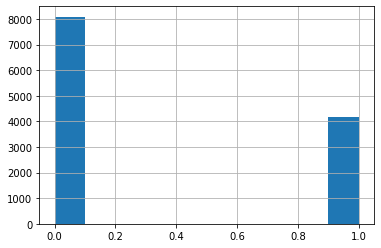

In [86]:
import pandas as pd

trainTargets['well_above_median'].hist()

In [87]:
trainTargets

,house_value,stratification_category,well_above_median,house_value_level
18973,241600.0,2,1,2
18676,124600.0,0,0,0
7677,275700.0,2,1,2
10871,298400.0,2,1,2
6037,122200.0,0,0,0
...,...,...,...,...
11433,122600.0,0,0,0
19004,164500.0,1,0,1
7180,287700.0,2,1,2
14016,201200.0,1,0,1


In [88]:
# We can see that the 1.0 class is the underrepresented class, so we'll oversample that.

# First, lets recombine our targets with the features so it's a little easier to sample.
trainFeaturesWithTargets = trainFeaturesScaled.merge(trainTargets, left_index=True, right_index=True)
trainFeaturesWithTargets

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,house_value,stratification_category,well_above_median,house_value_level
18973,0.710711,0.024468,0.725490,0.067653,0.080045,0.069255,0.092402,0.241776,241600.0,2,1,2
18676,0.681682,0.146809,0.490196,0.075487,0.092608,0.132070,0.103976,0.238086,124600.0,0,0,0
7677,0.206206,0.560638,1.000000,0.088484,0.120792,0.088394,0.133844,0.234486,275700.0,2,1,2
10871,0.596597,0.141489,0.588235,0.079353,0.116927,0.115446,0.133284,0.232121,298400.0,2,1,2
6037,0.702703,0.172340,0.490196,0.078946,0.096956,0.085450,0.107336,0.184391,122200.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11433,0.250250,0.765957,0.196078,0.183377,0.218071,0.200037,0.235766,0.180177,122600.0,0,0,0
19004,0.286286,0.640426,1.000000,0.078285,0.087615,0.059625,0.092216,0.225935,164500.0,1,0,1
7180,0.219219,0.578723,0.176471,0.072791,0.082622,0.079561,0.094456,0.268107,287700.0,2,1,2
14016,0.640641,0.162766,0.607843,0.052546,0.057175,0.059686,0.068882,0.324968,201200.0,1,0,1


In [90]:
diff = len(trainFeaturesWithTargets[trainFeaturesWithTargets['well_above_median'] == 0])  - len(trainFeaturesWithTargets[trainFeaturesWithTargets['well_above_median'] == 1])
diff
newSample = trainFeaturesWithTargets[trainFeaturesWithTargets['well_above_median'] == 1].sample(n=diff, replace=True)
newSample.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,house_value,stratification_category,well_above_median,house_value_level
count,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.0,3919.0,3919.0
mean,0.448281,0.305999,0.570604,0.074012,0.088077,0.081231,0.096078,0.335597,340343.192651,2.0,1.0,2.0
std,0.202676,0.200063,0.259673,0.053901,0.065229,0.059169,0.069262,0.152691,91574.701591,0.0,0.0,0.0
min,0.122122,0.001064,0.019608,0.000153,0.000000,0.000000,0.000000,0.002490,228000.000000,2.0,1.0,2.0
25%,0.225225,0.143617,0.352941,0.042881,0.049042,0.046927,0.054695,0.232583,262100.000000,2.0,1.0,2.0
50%,0.579580,0.174468,0.568627,0.062262,0.071509,0.066740,0.078589,0.314147,315500.000000,2.0,1.0,2.0
75%,0.619620,0.524468,0.745098,0.088522,0.106297,0.099405,0.116390,0.404681,404400.000000,2.0,1.0,2.0
max,0.801802,0.707447,1.000000,0.640546,0.872604,0.733223,0.920105,1.000000,500001.000000,2.0,1.0,2.0


<AxesSubplot:ylabel='Frequency'>

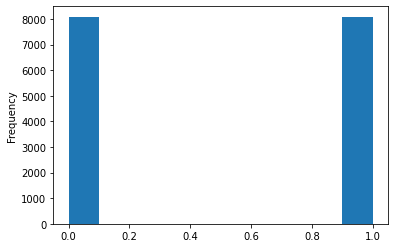

In [91]:
trainFeaturesWithTargetsBalanced = pd.concat([trainFeaturesWithTargets, newSample])

trainFeaturesScaledBalanced = trainFeaturesWithTargetsBalanced[trainFeatures.columns]
trainTargetsBalanced = trainFeaturesWithTargetsBalanced[trainTargets.columns]
trainTargetsBalanced['well_above_median'].plot.hist()

Once you've made a balanced dataset, you can go ahead and make your training and development splits.

In [92]:
logisticRegBinaryBalanced = LogisticRegression()
logisticRegBinaryBalanced.fit(trainFeaturesScaledBalanced, trainTargetsBalanced['well_above_median'])

devLogisticRegBinaryBalancedPred = logisticRegBinaryBalanced.predict(devFeaturesScaled)
devLogisticRegBinaryBalancedProbs = logisticRegBinaryBalanced.predict_proba(devFeaturesScaled)

print('Balanced:')
evaluateBinaryClassification(devTargets['well_above_median'], devLogisticRegBinaryBalancedPred, devLogisticRegBinaryBalancedProbs)


# Unbalanced:
print('\nUnbalanced:')
evaluateBinaryClassification(devTargets['well_above_median'], devLogisticRegBinaryPred, devLogisticRegBinaryProbs)

Balanced:
Accuracy    : 0.8202
Precision   : 0.6981
Recall      : 0.8302
F1          : 0.7585
AUC         : 0.9143

Unbalanced:
Accuracy    : 0.8427
Precision   : 0.8049
Recall      : 0.7094
F1          : 0.7541
AUC         : 0.9107


In [94]:
# from sklearn.tree import DecisionTreeClassifier

decisionTreeBinaryBalanced  = DecisionTreeClassifier(max_leaf_nodes=300)
decisionTreeBinaryBalanced.fit(trainFeaturesScaledBalanced.values, trainTargetsBalanced['well_above_median'])
decisionTreeBinaryBalancedPred = decisionTreeBinaryBalanced.predict(devFeaturesScaled.values, )
decisionTreeBinaryBalancedProbs = decisionTreeBinaryBalanced.predict_proba(devFeaturesScaled.values)

print('Balanced:')
evaluateBinaryClassification(devTargets['well_above_median'], decisionTreeBinaryBalancedPred, decisionTreeBinaryBalancedProbs)

print('\nUnbalanced:')
evaluateBinaryClassification(devTargets['well_above_median'], decisionTreeBinaryPred, decisionTreeBinaryProbs)

Balanced:
Accuracy    : 0.8735
Precision   : 0.7943
Recall      : 0.8475
F1          : 0.8200
AUC         : 0.9029

Unbalanced:
Accuracy    : 0.8762
Precision   : 0.8284
Recall      : 0.8022
F1          : 0.8151
AUC         : 0.8794


# Next steps

There are LOTS of other classification and regression models out there—check out [the Scikit Learn website](https://scikit-learn.org/stable/index.html) for more. They follow pretty similar patterns. Each algorithm also has several parameters you can adjust, so be sure to read the documentation pages and guides to find out how to tweak them.

Scikit Learn also has a construct called *pipelines*, which I haven't gone over in this notebook. You can find out more about those [here](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=782e03d4-dc01-4ed9-bfc4-f8eae673da93' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>